In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import torchaudio
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import jiwer


def load_audio(file_path):
    speech_array,sampling_rate = torchaudio.load(file_path)
    if sampling_rate != 16000:
        speech_array = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)(speech_array)
    return speech_array.squeeze().numpy()


def load_text(file_path):
    with open(file_path, 'r') as file:
        return file.read().strip()

def evaluate_cer_wer_scores(audio_dir, text_dir):
    print("Initializing Wav2Vec2 model and processor...")
    model_name = 'facebook/wav2vec2-large-robust-ft-libri-960h'
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    model = Wav2Vec2ForCTC.from_pretrained(model_name)
    model.eval()
    print("Model initialization complete.")

#variables

    cer_scores = []
    wer_scores = []
    total_samples = 0
    skipped_files = []

    for audio_file in os.listdir(audio_dir):
        if audio_file.endswith('.wav'):
            audio_path = os.path.join(audio_dir, audio_file)
            text_file = audio_file.replace('.wav', '.txt')
            text_path = os.path.join(text_dir, text_file)

            if os.path.exists(text_path):
                # Load and preprocess the audio
                input_audio = load_audio(audio_path)
                input_values = processor(input_audio, sampling_rate=16000, return_tensors="pt").input_values

                # Perform ASR
                with torch.no_grad():
                    logits = model(input_values).logits
                predicted_ids = torch.argmax(logits, dim=-1)
                transcription = processor.batch_decode(predicted_ids)[0]

                # Load reference transcription
                reference = load_text(text_path)

                # Skip empty references
                if not reference.strip():
                    print(f"Skipping file {audio_file} due to empty reference.")
                    skipped_files.append(audio_file)
                    continue

                try:
                    # Compute CER and WER
                    cer = jiwer.cer(reference, transcription)
                    wer = jiwer.wer(reference, transcription)
                    cer_scores.append(cer)
                    wer_scores.append(wer)
                    total_samples += 1

                    print(f"File: {audio_file}")
                    print(f"Reference: {reference}")
                    print(f"Transcriptions: {transcription}")
                    print("Computing CER and WER...")
                    print(f"CER: {cer:.4f}")
                    print(f"WER: {wer:.4f}")
                except ValueError as e:
                    print(f"Error processing file {audio_file}: {str(e)}")
                    skipped_files.append(audio_file)

    if total_samples > 0:
        average_cer = sum(cer_scores) / total_samples
        average_wer = sum(wer_scores) / total_samples
        print(f"Average CER Value: {average_cer:.4f}")
        print(f"Average WER Value: {average_wer:.4f}")
    else:
        print("No valid samples processed.")

    if skipped_files:
        print(f"Skipped files: {', '.join(skipped_files)}")

    return cer_scores



audio_directory = '/content/drive/MyDrive/dataset/audio'
text_directory = '/content/drive/MyDrive/dataset/transcriptions'
cer_value=evaluate_cer_wer_scores(audio_directory, text_directory)

Initializing Wav2Vec2 model and processor...


Some weights of the model checkpoint at facebook/wav2vec2-large-robust-ft-libri-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-robust-ft-libri-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You

Streaming output truncated to the last 5000 lines.
Computing CER and WER...
CER: 0.0581
WER: 0.2222
File: 0007ded624990bde81e904aa95a7390dc3c885c2c3c87a6c01a43379.wav
Reference: GAMMA ONE THEN THAT MEANS IT IS A GAMMA ONE IT IS GAMMA ONE SO NOW D EQUAL TO ZERO MEANS E
Transcriptions: AMAON A THEN THAT MINCE IT IS IT IS E IT IS A GAMA ONE OKAY IT IS GAMA ON SO NOW DEIQUAL TO GIROMINS E
Computing CER and WER...
CER: 0.4000
WER: 0.7273
File: 000a087eebdf041ef1bac20fe12e45212399f366e830638edf200291.wav
Reference: THE WAVE ON THE SHIP WHICH IS NOTHING BUT INTEGRATION
Transcriptions: THAT WAVE A OOM ON THE SHIP AND IA WHICH IS NOTHING BUT INTEGRATIO
Computing CER and WER...
CER: 0.3019
WER: 0.6000
File: 0009d963fe08227f3a2acb4f0b5c5c8b614f0ee4a1fd29df6b30269f.wav
Reference: THE ACETONE AND P T IS THE TOTAL PRESSURE OF THE SYSTEM P V IS THE VAPOR PRESSURE GAMMA IS ACTIVITY COEFFICIENT
Transcriptions: THE ACITON AND PITY IS THE TOTAL PRESSURE OF THE SYSTEM PEVIIS THE VEPER PRESSURE GAMI'S ACTI

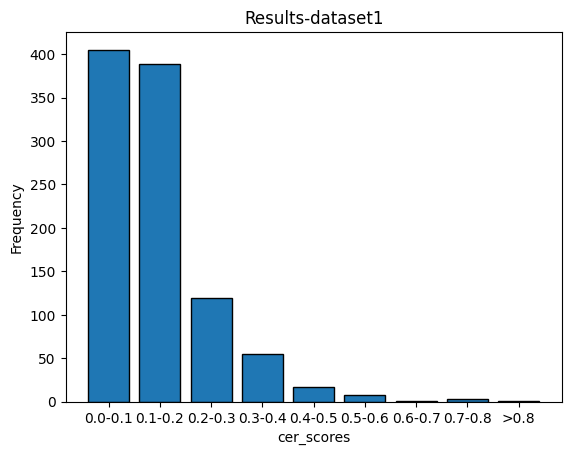

In [14]:
import numpy as np
import matplotlib.pyplot as plt


bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, float('inf')]
bin_counts = np.histogram(cer_value, bins=bins)[0]
bin_labels = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '>0.8']
plt.bar(bin_labels, bin_counts, edgecolor='black')
plt.xlabel('cer_scores')
plt.ylabel('Frequency')
plt.title('Results-dataset1')
plt.show()

In [13]:
cer_value

[0.16666666666666666,
 0.3023255813953488,
 0.1415929203539823,
 0.07291666666666667,
 0.03488372093023256,
 0.14285714285714285,
 0.12154696132596685,
 0.11290322580645161,
 0.14634146341463414,
 0.11290322580645161,
 0.10843373493975904,
 0.13636363636363635,
 0.0989010989010989,
 0.08139534883720931,
 0.037037037037037035,
 0.08139534883720931,
 0.02586206896551724,
 0.08602150537634409,
 0.09523809523809523,
 0.12195121951219512,
 0.05319148936170213,
 0.15254237288135594,
 0.10843373493975904,
 0.0963855421686747,
 0.10687022900763359,
 0.15053763440860216,
 0.0425531914893617,
 0.08620689655172414,
 0.12903225806451613,
 0.010752688172043012,
 0.02631578947368421,
 0.12359550561797752,
 0.08139534883720931,
 0.043478260869565216,
 0.1951219512195122,
 0.011904761904761904,
 0.0,
 0.17045454545454544,
 0.056179775280898875,
 0.1349206349206349,
 0.03529411764705882,
 0.043010752688172046,
 0.5154639175257731,
 0.09333333333333334,
 0.25396825396825395,
 0.047619047619047616,
 0.05